# Test RAMS Deep Neural Network on Proba-V Dataset
![proba_v_dataset](media/RAMS.png "Logo Title Text 1")

The following notebook provides a script to test the pre-trained or re-trained model (if you use the training notebook) using the weights stored in the 'ckpt' folder. The testing is performed with the validation set composed of all the scenes used to evaluate our network and all significant solutions presented in literature at the time of writing. Results can be found in the following table. Your aim is to beat the last row :)

![table_results](media/probav_results_summary.png "Logo Title Text 1")

**NB**: The last chapter of this notebook allows to make predictions with the original test set (ground truth are not public) of the Proba-V ESA challenge. After prediction and zip creation you can submit your file on the official post-mortem challenge, [here](https://kelvins.esa.int/proba-v-super-resolution-post-mortem/home/), and find out your score.

**The notebook is divided in**:
- 1.0 [Dataset Loading](#loading)
- 2.0 [Load the Network](#network)
- 3.0 [Test the network](#test)
    - 3.1 Qualitative results
    - 3.2 Compute RAMS cPSNR
    - 3.3 Compute RAMS+ cPSNR
    - 3.4 Compute RAMS SSIM
    - 3.5 Computer RAMS+ SSIM
- 4.0 [Predict Proba-V Test Set](#proba)
    - 4.1 RAMS prediction
    - 4.2 RAMS+ prediction
    - 4.3 Submission zip creation

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# %pip install tqdm --upgrade --user
# %pip install --upgrade tensorflow --user
%pip install --upgrade pip setuptools wheel --user
%pip install opencv-python
%pip install --upgrade scikit-image
%pip install --upgrade tensorflow-addons


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# import utils and basic libraries
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import LayerNormalization
import tensorflow as tf
from utils.preprocessing import gen_sub, bicubic
from utils.loss import l1_loss, psnr, ssim
from utils.prediction import ensemble, unensemble, shuffle_last_axis, predict_tensor, predict_tensor_permute, savePredictions, savePredictionsPermut
from utils.network import RAMS
from utils.training import Trainer
from skimage import io
from zipfile import ZipFile

In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# gpu setting (we strongly discouraged to run this notebook without an available GPU)
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.random.set_seed(42)

In [5]:
#-------------
# General Settings
#-------------
PATH_DATASET = 'dataset' # pre-processed dataset path
name_net = 'RAMS' # name of the network
LR_SIZE = 32 # pathces dimension
SCALE = 3 # upscale of the proba-v dataset is 3
HR_SIZE = LR_SIZE * SCALE # upscale of the dataset is 3
OVERLAP = 32 # overlap between pathces
CLEAN_PATH_PX = 0.85 # percentage of clean pixels to accept a patch
band = 'RED' # choose the band for the training
checkpoint_dir = 'ckpt/burst_RAMS_w_BURSTSR_retrain' # weights path
log_dir = 'logs' # tensorboard logs path
submission_dir = 'submission' # submission dir
name_zip = 'submission_RAMS.zip'

In [6]:
#-------------
# Network Settings
#-------------
FILTERS = 32 # features map in the network
KERNEL_SIZE = 3 # convolutional kernel size dimension (either 3D and 2D)
CHANNELS = 9 # number of temporal steps
R = 8 # attention compression
N = 12 # number of residual feature attention blocks
lr = 1e-4 # learning rate (Nadam optimizer)
BATCH_SIZE = 32 # batch size
EPOCHS_N = 100 # number of epochs

<a id="loading"></a>
# 1.0 Dataset Loading

In [7]:
# load validation 
X_val = np.load(os.path.join(PATH_DATASET, f'X_burst_val.npy'))
y_val = np.load(os.path.join(PATH_DATASET, f'y_burst_val.npy'))
y_val_mask = np.load(os.path.join(PATH_DATASET, f'y_burst_val_masks.npy'))

In [8]:
# print loaded dataset info
print('X_val: ', X_val.shape)
print(X_val.std())
print('y_val: ', y_val.shape)
print('y_val_mask: ', y_val_mask.shape)

X_val:  (200, 128, 128, 9)
52.17694409093816
y_val:  (200, 384, 384, 1)
y_val_mask:  (200, 384, 384, 1)


<a id="network"></a>
# 2.0 Load the Network

In [9]:
# build rams network
rams_network = RAMS(scale=SCALE, filters=FILTERS, 
                 kernel_size=KERNEL_SIZE, channels=CHANNELS, r=R, N=N)

2022-01-11 16:45:01.242196: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-11 16:45:02.036337: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5362 MB memory:  -> device: 0, name: GeForce GTX 980 Ti, pci bus id: 0000:05:00.0, compute capability: 5.2


In [10]:
# load weights from checkpoint_dir
checkpoint = tf.train.Checkpoint(step=tf.Variable(0),
                                psnr=tf.Variable(1.0),
                                model=rams_network)
print(tf.train.latest_checkpoint(checkpoint_dir))
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

ckpt/burst_RAMS_w_BURSTSR_retrain/ckpt-7500


<a id="test"></a>
# 3.0 Test the Network

## 3.1 Qualitative results

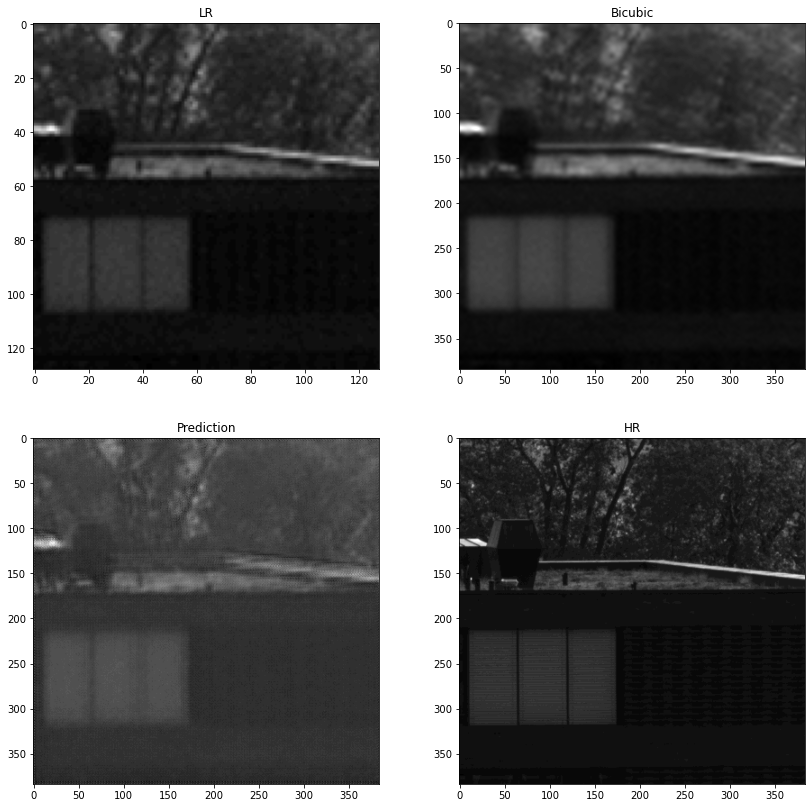

In [25]:
# print example images
index = 8 # choose an image fom validation set

x_pred = predict_tensor(rams_network, X_val[index:index+1])
fig, ax = plt.subplots(2,2, figsize=(14,14))
ax[0,0].imshow(X_val[index,:,:,0], cmap = 'gray')
ax[0,0].set_title('LR')
ax[0,1].imshow(bicubic(np.mean(X_val[index:index+1], axis=-1)[...,None])[0,:,:,0], cmap ='gray')
ax[0,1].set_title('Bicubic')
ax[1,0].imshow(x_pred[0,:,:,0], cmap ='gray')
ax[1,0].set_title('Prediction')
ax[1,1].imshow(y_val[index,:,:,0], cmap = 'gray')
ax[1,1].set_title('HR')
fig.show()

## 3.2 Compute RAMS cPSNR

In [29]:
# compute cPSNR with trained network
psnr_scores = []

for index in tqdm(range(X_val.shape[0])):
    x_pred = predict_tensor(rams_network, X_val[index:index+1])
    psnr_scores.append(psnr(y_val[index:index+1,:,:], x_pred, y_val_mask[index:index+1,:,:], HR_SIZE).numpy())

  0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# print validation network cPSNR
print(f'PSNR Validation Network: {np.mean(psnr_scores)}')

In [ ]:
# compute cPSNR with bicubic interpolation
psnr_scores_bicubic = []

for index in tqdm(range(X_val.shape[0])):
    x_pred = bicubic(np.mean(X_val[index:index+1], axis=-1)[...,None])
    psnr_scores_bicubic.append(psnr(y_val[index:index+1,:,:], x_pred, y_val_mask[index:index+1,:,:], HR_SIZE).numpy())

In [ ]:
# print validation bicubic cPSNR
print(f'PSNR Validation Bicubic: {np.mean(psnr_scores_bicubic)}')

In [ ]:
# show bicubic vs network comparison
plt.rc('font', size=25)          # controls default text sizes
fig,ax = plt.subplots(figsize=(10,10))

ax.plot(np.arange(30,70,0.5),np.arange(30,70,0.5),'black',linewidth=0.5)
ax.fill_between(np.arange(20,70,0.5), 0, np.arange(20,70,0.5), color = (0/255, 0/255, 230/255, 0.3))
ax.fill_between(np.arange(20,70,0.5), np.arange(20,70,0.5), 70, color = (0/255, 0/255, 230/255, 0.1))

ax.plot(psnr_scores_bicubic, psnr_scores,'x',color='black')

plt.xticks(np.arange(30, 65, step=10))
plt.yticks(np.arange(30, 65, step=10))
plt.ylabel("mPSNR RAMS")
plt.xlabel("mPSNR Bicubic")
ax.axis((25,65,25,65))
ax.set_aspect('equal')
ax.grid(color = 'gray',linestyle='dotted')

## 3.3 Compute RAMS+ cPSNR

In [ ]:
# compute Ensemble PSNR prediction
psnr_scores_plus = []
n_permut = 20 # number of permutations

for index in tqdm(range(X_val.shape[0])):
    x_pred = predict_tensor_permute(rams_network, X_val[index],n_ens=n_permut)
    psnr_scores_plus.append(psnr(y_val[index:index+1,:,:], x_pred, y_val_mask[index:index+1,:,:], HR_SIZE).numpy())

In [ ]:
# print validation Ensamble cPSNR
print(f'PSNR Validation Ensamble: {np.mean(psnr_scores_plus)}')

## 3.4 Compute RAMS SSIM

In [ ]:
# compute SSIM with trained network
ssim_scores = []

for index in tqdm(range(X_val.shape[0])):
    x_pred = predict_tensor(rams_network, X_val[index:index+1])
    ssim_scores.append(ssim(y_val[index:index+1,:,:], x_pred, y_val_mask[index:index+1,:,:], HR_SIZE).numpy())

In [ ]:
# print validation network SSIM
print(f'SSIM Validation Network: {np.mean(ssim_scores)}')

## 3.5 Computer RAMS+ SSIM

In [ ]:
# compute Ensemble SSIM prediction
ssim_scores_ens = []
n_permut = 20 # number of permutations

for index in tqdm(range(X_val.shape[0])):
    x_pred = predict_tensor_permute(rams_network, X_val[index],n_ens=n_permut)
    ssim_scores_ens.append(ssim(y_val[index:index+1,:,:], x_pred, y_val_mask[index:index+1,:,:], HR_SIZE).numpy())

In [ ]:
# print validation Ensamble SSIM
print(f'PSNR Validation: {np.mean(ssim_scores_ens)}')

<a id="proba"></a>
# 4.0 Predict Proba-V Test Set

In [ ]:
# create submission folder
if not os.path.exists(submission_dir):
    os.mkdir(submission_dir)

## 4.1 RAMS prediction

In [ ]:
X_val.shape

In [ ]:
X_test.shape

In [ ]:
# predict proba-v test set with RAMS
X_preds = []

for index in tqdm(range(X_test.shape[0])):
    X_preds.append(predict_tensor(rams_network, X_test[index:index+1]))

In [ ]:
savePredictions(X_preds, band, submission_dir)

## 4.2 RAMS+ prediction

In [ ]:
# predict proba-v test set with RAMS+
X_preds = []
n_permut = 20 # number of permutations

for index in tqdm(range(X_test.shape[0])):
    X_preds.append(predict_tensor_permute(rams_network, X_test[index], n_ens=n_permut))

In [ ]:
# save predictions in submission_dir
savePredictionsPermut(X_preds, band, submission_dir)

## 4.3 Submission zip creation

In [ ]:
# zip creation
zf = ZipFile(name_zip, mode='w')
with tqdm(total=290, desc="Zipping images") as pbar:
    for i, img in enumerate(sorted(os.listdir(submission_dir))):
        zf.write(os.path.join(submission_dir, img), arcname=img)
        pbar.update(1)
zf.close()
print('Done!')

In [ ]:
def savePredictions(x, band, submission_dir):
    """RAMS save util"""
    if band == 'NIR':
        i = 1306
    elif band=='RED':
        i = 1160
        
    for index in tqdm(range(len(x))):
        io.imsave(os.path.join(submission_dir, f'imgset{i}.png'), x[index][0,:,:,0].numpy().astype(np.uint16),
                  check_contrast=False)
        i+=1